In [32]:
import pandas as pd
import numpy as np
import json
import traceback, sys
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from IPython.display import display

In [33]:
# Adjust the display width for the "Range" column
pd.set_option('display.max_colwidth', 200)  # Set to desired width
# Remove all warnings
import warnings
warnings.filterwarnings('ignore')

In [34]:
BASE_PATH = "/Users/shamweelmohammed/Desktop/Masters/Research/trace/analysis/output/june_7/inference_after_model_load/"

In [35]:
REPORTS_PATH = "/Users/shamweelmohammed/Desktop/Masters/Research/trace/apr19/reports_inference_profile_llama_apr19_3_bsz_1/"

# Helpers

In [36]:
def prepare_data(df, threshold, time_percentage_col, operation_col):
    small_slices = df[df[time_percentage_col] < threshold]
    if not small_slices.empty:
        other_data = pd.DataFrame({time_percentage_col: [small_slices[time_percentage_col].sum()], 
                                   operation_col: ['Others']})
        df = pd.concat([df[df[time_percentage_col] >= threshold], other_data], ignore_index=True)
    return df

In [37]:
def get_others_items(df, threshold, time_percentage_col, operation_col):
    small_slices = df[df[time_percentage_col] < threshold]
    if not small_slices.empty:
        other_items = small_slices[operation_col].tolist()
        return other_items
    else:
        return []

In [38]:
def plot_pie_chart(df, title, threshold, percentage_col, stat_col, stat_base, operation_col, colors, legend_title, plt_title, figsize=(10, 10)):
    # Prepare the data for the pie chart
    df_filtered = prepare_data(df, threshold, percentage_col, operation_col)
    
    # Get the items that are grouped as others
    others_items = get_others_items(df, threshold, percentage_col, operation_col)
    
    # Setup pie chart plot
    plt.figure(figsize=figsize)  # Increase figure size for better readability

    # Plot pie chart without showing percentages on the pie
    # wedges, texts, autotexts = plt.pie(df_filtered[percentage_col],
    #                                    startangle=140, colors=colors, textprops={'fontsize': 12}, autopct='%1.1f%%')
    # wedges, texts = plt.pie(df_filtered[percentage_col], startangle=140, colors=colors, textprops={'fontsize': 12})
    wedges, texts = plt.pie(df_filtered[percentage_col], startangle=140, colors=colors, textprops={'fontsize': 14})

    # Calculate the percentages for the pie chart
    total = sum(df_filtered[percentage_col])
    percentages = [f'{(x/total) * 100:.3f}%' for x in df_filtered[percentage_col]]

    # Round time values to four decimal places and add suffix
    df_filtered["Stat_Col"] = df_filtered[stat_col].apply(lambda x: f'{x:.2f} {stat_base}')

    # Each operation must not be more than 50 characters
    df_filtered[operation_col] = df_filtered[operation_col].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)
    
    # Create custom labels for each slice with times included
    legend_labels = [f'{op} - {perc} ({stat})' for op, perc, stat in zip(df_filtered[operation_col], percentages, df_filtered["Stat_Col"])]
    
    # Adding a legend to handle small slices or clarify the chart
    plt.legend(wedges, legend_labels, title=legend_title, loc="best", fontsize='small')

    # Better title display
    # plt.title(plt_title, fontsize=14, fontweight='bold')
    plt.title(plt_title, fontsize=16, fontweight='bold')
    
    # Show plot with adjustments
    plt.show()
    
    return others_items

In [39]:
def plot_bar_chart(df, title, threshold, percentage_col, stat_col, stat_base, operation_col, x_label, y_label, bar_label, bar_color='b', figsize=(8, 4), legends=True, bar_width = 0.35, xlabel_rotation=25):
    # Prepare the data for the bar chart
    df_bar = df.sort_values(by=percentage_col, ascending=False)
    
    # Set "Others" for items less than threshold
    df_bar = prepare_data(df_bar, threshold, percentage_col, operation_col)
    
    # Get the list of items that are aggregated into 'Others'
    other_items = get_others_items(df, threshold, percentage_col, operation_col)
    
    # Setup bar chart plot
    plt.figure(figsize=figsize)  # Increase figure size for better readability
    
    # Plot bar chart with additional information
    fig, ax = plt.subplots(figsize=figsize)
    
    index = np.arange(len(df_bar))
    
    # Each operation must not be more than 50 characters
    df_bar[operation_col] = df_bar[operation_col].apply(lambda x: x[:50])
    
    # Plot bars
    bar1 = ax.bar(index, df_bar[percentage_col], bar_width, label=bar_label, color=bar_color)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(df_bar[operation_col], rotation=xlabel_rotation)
    
    if legends:
        ax.legend()
        
    # Add data labels
    for i, v in enumerate(df_bar[percentage_col]):
        ax.text(i, v + 0.5, str(round(v, 2)), color='black', ha='center')
        # ax.text(i, v + 0.01, f'{v:.4f}', color='black', ha='center')
        
    plt.grid(True)  # Add grid for better visibility
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()
    
    return other_items

In [40]:
def plot_time(df, title, limit, time_col, name_col, label_col, x_label, y_label, legend_label, bar_color='b', figsize=(12, 6), legends = False, bar_width = 0.35, xlabel_rotation=45):
    # Prepare the data for the bar chart
    df_sorted = df.sort_values(by=time_col, ascending=False).head(limit)
    
    # Setup bar chart plot
    plt.figure(figsize=figsize)  # Increase figure size for better readability
    
    bar_width = 0.35  # Increase bar width for better visibility
    index = np.arange(len(df_sorted))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bars
    bars = ax.bar(index, df_sorted[time_col], bar_width, label=legend_label, color=bar_color)
    
    # ax.set_xlabel(x_label, fontsize=14)
    # ax.set_ylabel(y_label, fontsize=14)
    # ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    ax.set_xticks(index)
    # ax.set_xticklabels(df_sorted[name_col], rotation=xlabel_rotation, fontsize=12)  # Use operation names as labels
    ax.set_xticklabels(df_sorted[name_col], rotation=xlabel_rotation, fontsize=14)  # Use operation names as labels
    
    if legends:
        # ax.legend(fontsize=12)
        ax.legend(fontsize=14)
    
    # Add data labels from label_col
    for bar in bars:
        yval = bar.get_height()
        # ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02*max(df_sorted[time_col]), f'{yval:.2f}', ha='center', va='bottom', fontsize=10)
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02*max(df_sorted[time_col]), f'{yval:.2f}', ha='center', va='bottom', fontsize=14)
        
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

In [41]:
def convert_string_to_dataframe(json_string):
    try:
        # Step 1: Replace single quotes with double quotes
        json_string = json_string.replace("'", '"')
        
        # Step 2: Fix for `nan` values, replacing them with null (JSON equivalent of NaN)
        json_string = re.sub(r'\bnan\b', 'null', json_string)
        
        # Replace None with null
        json_string = re.sub(r'\bNone\b', 'null', json_string)
        
        # Step 3: Parse the cleaned JSON string into a Python object
        list_of_dicts = json.loads(json_string)
        
        # Step 4: Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(list_of_dicts)

        return df
    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error parsing JSON string: {e}")
        return None

In [42]:
# Get unique Kernel Names
df_unique_kernel_names = pd.read_csv(REPORTS_PATH + "unique_kernel_names.csv")
unique_kernel_names = df_unique_kernel_names['kernel_name'].tolist()

In [43]:
# Function to map long names to short names
def map_kernel_name(long_name):
    for short_name in unique_kernel_names:
        if short_name in long_name:
            return short_name
    return long_name

# NVTX Push Pop Processed

In [44]:
# # df_nvtx_pushpop_trace_processed.csv
df_nvtx_gpu_proj_trace_processed_csv_path = BASE_PATH + "test_nvtx_gpu_proj_trace_processed_1000.csv"
df_nvtx_gpu_proj_trace_processed = pd.read_csv(df_nvtx_gpu_proj_trace_processed_csv_path)

In [45]:
df_nvtx_gpu_proj_trace_processed.head(5)

,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,...,Memory Operation Names,CUDA API to Kernel Mapping,CUDA API to Memory Mapping,CUDA API Summary,Memory Summary by Size,Memory Summary by Time,Kernel Summary,Kernel Summary (Short Names),GPU Kernel CorrIDs,GPU Memory CorrIDs
0,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/fire/core.py:143', '/root/miniconda3/envs/llama-profiling/lib/pyth...",16043531075,2976,16043252391,475037,PushPop,734,734,1,1416,...,NaN,[],[],[],[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...",7396,NaN
1,"{'mod': 'torch', 'op': 'full', 'args': []}",16043531075,2976,16043274920,451488,PushPop,734,734,1,1417,...,NaN,[],[],[],[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...",7396,NaN
2,"aten::full, op_id = 1",16043531075,2976,16043354930,365098,PushPop,734,734,1,1418,...,NaN,[],[],[],[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...",7396,NaN
3,"aten::fill_, op_id = 3",16043531075,2976,16043404970,314108,PushPop,734,734,1,1419,...,NaN,[],[],[],[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 105781.0, 'TMed (ns)': 105781.0, 'TMin (ns)': 105781, 'TMax (ns)': 105781, 'TStdDev (ns)': nan, 'AAvg (ns)': 103729.0, '...",7396,NaN
4,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/fire/core.py:143', '/root/miniconda3/envs/llama-profiling/lib/pyth...",16043968421,2080,16043860857,281919,PushPop,734,734,1,1416,...,[CUDA memcpy Host-to-Device],[],[],[],"[{'Operation': '[CUDA memcpy Host-to-Device]', 'Total (MB)': 0.0, 'Count': 1, 'Avg (MB)': 0.0, 'Med (MB)': 0.0, 'Min (MB)': 0.0, 'Max (MB)': 0.0, 'StdDev (MB)': nan, 'Size_Percent': nan}]","[{'Operation': '[CUDA memcpy Host-to-Device]', 'Total Time (ns)': 2080, 'Count': 1, 'Avg (ns)': 2080.0, 'Med (ns)': 2080.0, 'Min (ns)': 2080, 'Max (ns)': 2080, 'StdDev (ns)': nan, 'Time (%)': 100.0}]",[],[],NaN,7410


### Reports Helpers

In [46]:
def plot_cuda_api_summary(data, title, threshold=1.0, time_percentage_col='Time (%)', operation_col='Operation', figsize=(6, 6)):
    # Prepare data
    # data = json.loads(data.values[0])
    data = data.values[0]
    
    # Convert to DataFrame
    df = convert_string_to_dataframe(data)
    
    # Plot pie chart
    # others_items = plot_pie_chart(df = df,
    #             title = title,
    #             threshold = threshold,
    #             time_percentage_col = time_percentage_col,
    #             legend_title = operation_col,
    #             operation_col = operation_col,
    #             colors = sns.color_palette("tab20", len(df)),
    #             plt_title = title,
    #             figsize=figsize)
    other_items = plot_pie_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Avg (ns)',
                stat_base = 'ns',
                legend_title = operation_col,
                operation_col = operation_col,
                colors = sns.color_palette("tab20", len(df)),
                plt_title = title,
                figsize=figsize)
    
    print(f"CUDA API Summary Pie Chart Others Items: {other_items}")
    
    # Plot bar chart
    # other_items = plot_bar_chart(df = df,
    #             title = title,
    #             threshold = threshold,
    #             time_percentage_col = time_percentage_col,
    #             operation_col = operation_col,
    #             figsize=figsize)
    other_items = plot_bar_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Time (s)',
                stat_base = 's',
                operation_col = operation_col,
                x_label = operation_col,
                y_label = time_percentage_col,
                bar_label = time_percentage_col,
                bar_color = 'b',
                figsize = figsize,
                legends = False,
                bar_width = 0.35,
                xlabel_rotation = 0)
    
    print(f"CUDA API Summary Bar Chart Others Items: {other_items}")

In [47]:
def plot_gpu_summary_time(data, title, threshold=1.0, time_percentage_col='Time (%)', operation_col='Operation', figsize=(6, 6)):
    # Prepare data
    # data = json.loads(data.values[0])
    
    # # Convert to DataFrame
    # df = pd.DataFrame(data)
    # data = json.loads(data.values[0])
    data = data.values[0]
    
    # Convert to DataFrame
    df = convert_string_to_dataframe(data)
    
    # Plot pie chart
    others_items = plot_pie_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Avg (ns)',
                stat_base = 'ns',
                legend_title = operation_col,
                operation_col = operation_col,
                colors = sns.color_palette("tab20", len(df)),
                plt_title = title,
                figsize=figsize)
    
    print(f"GPU Summary Time Pie Chart Others Items: {others_items}")
    
    # Plot bar chart
    # other_items = plot_bar_chart(df = df,
    #             title = title,
    #             threshold = threshold,
    #             time_percentage_col = time_percentage_col,
    #             operation_col = operation_col,
    #             figsize=figsize)
    # other_items = plot_bar_chart(df = df_cuda_memsize_summary,
    #             title = "CUDA Memory Size Summary (Percentage)",
    #             threshold = 1.0,
    #             time_percentage_col = 'Percent',
    #             operation_col = "Operation",
    #             x_label = "CUDA Memory Operations",
    #             y_label = "Size (%)",
    #             bar_label = "Size (%)",
    #             bar_color = 'brown',
    #             figsize = (8, 4),
    #             legends = False,
    #             bar_width = 0.35,
    #             xlabel_rotation = 0)
    
    other_items = plot_bar_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Avg (ns)',
                stat_base = 'ns',
                operation_col = operation_col,
                x_label = operation_col,
                y_label = time_percentage_col,
                bar_label = time_percentage_col,
                bar_color = 'b',
                figsize = figsize,
                legends = False,
                bar_width = 0.35,
                xlabel_rotation = 0)
    
    print(f"GPU Summary Time Bar Chart Others Items: {other_items}")

In [48]:
def plot_gpu_summary_size(data, title, threshold=1.0, time_percentage_col='Size_Percent', operation_col='Operation', figsize=(6, 6)):
    # Prepare data
    # data = json.loads(data.values[0])
    
    # # Convert to DataFrame
    # df = pd.DataFrame(data)
    # data = json.loads(data.values[0])
    data = data.values[0]
    
    # Convert to DataFrame
    df = convert_string_to_dataframe(data)
    
    # Plot pie chart
    others_items = plot_pie_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Avg (MB)',
                stat_base = 'MB',
                legend_title = operation_col,
                operation_col = operation_col,
                colors = sns.color_palette("tab20", len(df)),
                plt_title = title,
                figsize=figsize)
    
    print(f"GPU Summary Size Pie Chart Others Items: {others_items}")
    
    # Plot bar chart
    # other_items = plot_bar_chart(df = df,
    #             title = title,
    #             threshold = threshold,
    #             time_percentage_col = time_percentage_col,
    #             operation_col = operation_col,
    #             figsize=figsize)
    other_items = plot_bar_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Avg (MB)',
                stat_base = 'MB',
                operation_col = operation_col,
                x_label = operation_col,
                y_label = time_percentage_col,
                bar_label = time_percentage_col,
                bar_color = 'b',
                figsize = figsize,
                legends = False,
                bar_width = 0.35,
                xlabel_rotation = 0)
    
    print(f"GPU Summary Size Bar Chart Others Items: {other_items}")

In [49]:
def plot_kernel_functions_summary(data, title, threshold=1.0, time_percentage_col='Time (%)', operation_col='Operation', figsize=(6, 6)):
    # Prepare data
    # data = json.loads(data.values[0])
    
    # # Convert to DataFrame
    # df = pd.DataFrame(data)
    # data = json.loads(data.values[0])
    data = data.values[0]
    
    # Convert to DataFrame
    df = convert_string_to_dataframe(data)
    
    # Plot pie chart
    others_items = plot_pie_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Time (s)',
                stat_base = 's',
                legend_title = operation_col,
                operation_col = operation_col,
                colors = sns.color_palette("tab20", len(df)),
                plt_title = title,
                figsize=(15, 15))
    
    print(f"Kernel Functions Summary Pie Chart Others Items: {others_items}")
    
    # Plot bar chart
    # other_items = plot_bar_chart(df = df,
    #             title = title,
    #             threshold = threshold,
    #             time_percentage_col = time_percentage_col,
    #             operation_col = operation_col,
    #             figsize=figsize)
    other_items = plot_bar_chart(df = df,
                title = title,
                threshold = threshold,
                percentage_col = time_percentage_col,
                stat_col = 'Time (s)',
                stat_base = 's',
                operation_col = operation_col,
                x_label = operation_col,
                y_label = time_percentage_col,
                bar_label = time_percentage_col,
                bar_color = 'b',
                figsize=(15, 15),
                legends = False,
                bar_width = 0.35,
                xlabel_rotation = 0)
    
    print(f"Kernel Functions Summary Bar Chart Others Items: {other_items}")

# Analyse Operations

In [50]:
def analyze_api_call_frequency(df_block):
    cuda_api_summary = df_block['CUDA API Summary']
    
    if cuda_api_summary.empty:
        print("No data found for API Call Frequency Analysis")
        return
    
    df_cuda_api_summary = convert_string_to_dataframe(cuda_api_summary.values[0])
    
    if df_cuda_api_summary.empty:
        print("No data found in CUDA API Summary")
        return
    
    api_frequency = df_cuda_api_summary[['Operation', 'Instances']]
    api_frequency = api_frequency.sort_values(by='Instances', ascending=False)
    
    print("API Call Frequency Analysis:")
    display(api_frequency.sort_values(by='Instances', ascending=False))

In [51]:
def analyze_kernel_latency(df_block):
    kernels = df_block['Kernels']
    
    if kernels.empty:
        print("No data found for Kernel Latency Analysis")
        return
    
    df_kernels = convert_string_to_dataframe(kernels.values[0])
    
    if df_kernels.empty:
        print("No data found in Kernels")
        return
    
    latency_data = df_kernels[['Kernel Name', 'API Start (ns)', 'Kernel Start (ns)', 'Kernel Dur (ns)']]
    latency_data['Latency (ns)'] = latency_data['Kernel Start (ns)'] - latency_data['API Start (ns)']
    
    print("Kernel Latency Analysis:")
    display(latency_data.sort_values(by='Latency (ns)', ascending=False))
        
def analyze_kernel_execution_distribution(df_block):
    kernel_summary = df_block['Kernel Summary (Short Names)']
    
    if kernel_summary.empty:
        print("No data found for Kernel Execution Distribution Analysis")
        return
    
    df_kernel_summary = convert_string_to_dataframe(kernel_summary.values[0])
    
    if df_kernel_summary.empty:
        print("No data found in Kernel Summary")
        return
    
    kernel_distribution = df_kernel_summary[['Kernel Name', 'Count']]
    kernel_distribution = kernel_distribution.sort_values(by='Count', ascending=False)
    
    print("Kernel Execution Distribution Analysis:")
    display(kernel_distribution.sort_values(by='Count', ascending=False))


In [52]:
def analyze_memory_bandwidth_utilization(df_block):
    memory_ops = df_block['Memory Ops']
    
    df_memory_ops = convert_string_to_dataframe(memory_ops.values[0])
    
    if df_memory_ops.empty:
        print("No data found in Memory Ops")
        return
    
    bandwidth_data = df_memory_ops[['Name', 'Duration (ns)', 'Bytes (MB)']]
    bandwidth_data['Bandwidth (GB/s)'] = (bandwidth_data['Bytes (MB)'] * 1024) / (bandwidth_data['Duration (ns)'] * 1e-9)
    
    print("Memory Bandwidth Utilization Analysis:")
    display(bandwidth_data.sort_values(by='Bandwidth (GB/s)', ascending=False))

In [53]:
import matplotlib.pyplot as plt

def plot_concurrency_overlapping(df_concurrency, title, figsize=(10, 6)):
    """
    Plots concurrency overlapping analysis.
    
    Parameters:
    df_concurrency (DataFrame): Dataframe containing concurrency overlapping data.
    title (str): Title of the plot.
    figsize (tuple): Size of the figure.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plotting the number of overlapping memory operations for each kernel
    ax.barh(df_concurrency['Kernel Name'], df_concurrency['Overlapping Memory Ops Count'], color='skyblue')
    
    ax.set_xlabel('Number of Overlapping Memory Operations')
    ax.set_ylabel('Kernel Name')
    ax.set_title(title)
    plt.show()


In [54]:
def concurrency_overlapping_analysis(df_block):
    kernels = df_block['Kernels']
    memory_ops = df_block['Memory Ops']
        
    if kernels.empty or memory_ops.empty:
        print("No data found for Concurrency Overlapping Analysis")
        return
    
    df_kernels = convert_string_to_dataframe(kernels.values[0])
    df_memory_ops = convert_string_to_dataframe(memory_ops.values[0])
    
    if df_kernels.empty or df_memory_ops.empty:
        print("No data found in Kernels or Memory Ops")
        return
    
    print("Concurrency Overlapping Analysis:")
    
    # Merging kernel and memory operation dataframes based on overlapping times
    df_kernels['End (ns)'] = df_kernels['Kernel Start (ns)'] + df_kernels['Kernel Dur (ns)']
    df_memory_ops['End (ns)'] = df_memory_ops['Start (ns)'] + df_memory_ops['Duration (ns)']
    
    concurrency_data = []
    for _, kernel_row in df_kernels.iterrows():
        overlapping_memory_ops = df_memory_ops[
            (df_memory_ops['Start (ns)'] < kernel_row['End (ns)']) &
            (df_memory_ops['End (ns)'] > kernel_row['Kernel Start (ns)'])
        ]
        if not overlapping_memory_ops.empty:
            concurrency_data.append({
                'Kernel Name': kernel_row['Kernel Name'],
                'Overlapping Memory Ops Count': len(overlapping_memory_ops),
                'Kernel Duration (ns)': kernel_row['Kernel Dur (ns)'],
                'Overlapping Memory Ops': overlapping_memory_ops['Name'].tolist()
            })
    
    if not concurrency_data:
        print("No significant overlapping found")
    else:
        df_concurrency = pd.DataFrame(concurrency_data)
        display(df_concurrency)
        
        # Plotting Overlapping Analysis
        plot_concurrency_overlapping(df_concurrency, "Concurrency Overlapping Analysis", figsize=(10, 6))


In [55]:
def display_block(name, df_nvtx_gpu_proj_trace_processed):
    df_block = df_nvtx_gpu_proj_trace_processed[df_nvtx_gpu_proj_trace_processed['Name'] == name].head(1)

    if df_block.empty:
        print(f"No data found for Name: {name}")
        return

    block_cuda_api_summary = df_block['CUDA API Summary']
    block_gpu_summary_time = df_block['Memory Summary by Time']
    block_gpu_summary_size = df_block['Memory Summary by Size']
    block_kernel_functions_summary = df_block['Kernel Summary (Short Names)']
    block_cuda_api_to_kernel_mapping = df_block['CUDA API to Kernel Mapping']
    block_cuda_api_to_memory_mapping = df_block['CUDA API to Memory Mapping']

    # CUDA API Summary
    # print 100 * "#"
    print("########################################################################################################")
    data = block_cuda_api_summary.values[0]
    df_block_cuda_api_summary = convert_string_to_dataframe(data)
    # Time (%)	Total Time (ns)	Instances	Avg (ns)	Med (ns)	Min (ns)	Max (ns)	StdDev (ns)	Operation
    if df_block_cuda_api_summary.empty:
        print(f"\n{name} - CUDA API Summary")
        print("No data found")
    else:
        # Print only Time (%), Total Time (ns), Instances, Avg (ns), Operation
        df_block_cuda_api_summary_sample = df_block_cuda_api_summary[['Time (%)', 'Total Time (ns)', 'Instances', 'Avg (ns)', 'Operation']]
        print(f"\n{name} - CUDA API Summary")
        display(df_block_cuda_api_summary_sample)
        
        # Plot CUDA API Summary
        plot_cuda_api_summary(block_cuda_api_summary, f"{name} - CUDA API Summary", figsize=(6, 6))
    
    print("########################################################################################################")
    
    # GPU Summary Time
    data = block_gpu_summary_time.values[0]
    df_block_gpu_summary_time = convert_string_to_dataframe(data)
    if df_block_gpu_summary_time.empty:
        print(f"\n{name} - GPU Summary Time")
        print("No data found")
    else:
        print(f"\n{name} - GPU Summary Time")
        display(df_block_gpu_summary_time)
        
        # Plot GPU Summary Time
        plot_gpu_summary_time(block_gpu_summary_time, f"{name} - GPU Summary Time", figsize=(4, 4))
    
    # GPU Summary Size
    data = block_gpu_summary_size.values[0]
    df_block_gpu_summary_size = convert_string_to_dataframe(data)
    
    if df_block_gpu_summary_size.empty:
        print(f"\n{name} - GPU Summary Size")
        print("No data found")
    else:
        print(f"\n{name} - GPU Summary Size")
        display(df_block_gpu_summary_size)
        
        # Plot GPU Summary Size
        plot_gpu_summary_size(block_gpu_summary_size, f"{name} - GPU Summary Size", figsize=(4, 4))
    
    print("########################################################################################################")
    
    # Kernel Functions Summary
    data = block_kernel_functions_summary.values[0]
    df_block_kernel_functions_summary = convert_string_to_dataframe(data)
    
    if df_block_kernel_functions_summary.empty:
        print(f"\n{name} - Kernel Functions Summary")
        print("No data found")
    else:
        sample_data = df_block_kernel_functions_summary[['Kernel Name', 'API Function', 'Count', 'KAvg (ns)']]
        print(f"\n{name} - Kernel Functions Summary")
        display(sample_data)
    
    print("########################################################################################################")
    
    # CUDA API to Kernel Mapping
    data = block_cuda_api_to_kernel_mapping.values[0]
    df_block_cuda_api_to_kernel_mapping = convert_string_to_dataframe(data)
    
    if df_block_cuda_api_to_kernel_mapping.empty:
        print(f"\n{name} - CUDA API to Kernel Mapping")
        print("No data found")
    else:
        df_block_cuda_api_to_kernel_mapping['Kernels'] = df_block_cuda_api_to_kernel_mapping['Kernels'].apply(lambda x: ', '.join(x))
        df_block_cuda_api_to_kernel_mapping = df_block_cuda_api_to_kernel_mapping.drop_duplicates()
        df_block_cuda_api_to_kernel_mapping['Kernels'] = df_block_cuda_api_to_kernel_mapping['Kernels'].apply(lambda x: map_kernel_name(x))
        print(f"\n{name} - CUDA API to Kernel Mapping")
        display(df_block_cuda_api_to_kernel_mapping)
    
    # CUDA API to Memory Mapping
    data = block_cuda_api_to_memory_mapping.values[0]
    df_block_cuda_api_to_memory_mapping = convert_string_to_dataframe(data)
    
    if df_block_cuda_api_to_memory_mapping.empty:
        print(f"\n{name} - CUDA API to Memory Mapping")
        print("No data found")
    else:
        print(f"\n{name} - CUDA API to Memory Mapping")
        # display(df_block_cuda_api_to_memory_mapping)
        # Split multiple values in Memory Operations into separate rows and then drop duplicates
        df_block_cuda_api_to_memory_mapping = df_block_cuda_api_to_memory_mapping.explode('Memory Operations').drop_duplicates()
        display(df_block_cuda_api_to_memory_mapping)
    
    print("########################################################################################################")
        
    ######### NEW FUNCTIONS #########
    # API Call Frequency Analysis
    analyze_api_call_frequency(df_block)
    
    # Kernel Latency Analysis
    analyze_kernel_latency(df_block)
    
    # Kernel Execution Distribution Analysis
    analyze_kernel_execution_distribution(df_block)
    
    # Memory Bandwidth Utilization Analysis
    analyze_memory_bandwidth_utilization(df_block)
    
    # Concurrency and Overlapping Analysis
    concurrency_overlapping_analysis(df_block)
    
    return df_block

## tok_embeddings: ParallelEmbedding

In [56]:
display_block('tok_embeddings: ParallelEmbedding', df_nvtx_gpu_proj_trace_processed)

########################################################################################################

tok_embeddings: ParallelEmbedding - CUDA API Summary
No data found
########################################################################################################

tok_embeddings: ParallelEmbedding - GPU Summary Time
No data found

tok_embeddings: ParallelEmbedding - GPU Summary Size
No data found
########################################################################################################

tok_embeddings: ParallelEmbedding - Kernel Functions Summary


,Kernel Name,API Function,Count,KAvg (ns)
0,indexSelectSmallIndex,cudaLaunchKernel,1,15264.0


########################################################################################################

tok_embeddings: ParallelEmbedding - CUDA API to Kernel Mapping
No data found

tok_embeddings: ParallelEmbedding - CUDA API to Memory Mapping
No data found
########################################################################################################
No data found in CUDA API Summary
Kernel Latency Analysis:


,Kernel Name,API Start (ns),Kernel Start (ns),Kernel Dur (ns),Latency (ns)
0,"void at::native::<unnamed>::indexSelectSmallIndex<c10::Half, long, unsigned int, (int)2, (int)2, (int)-2>(at::cuda::detail::TensorInfo<T1, T3>, at::cuda::detail::TensorInfo<T1, T3>, at::cuda::deta...",16056507437,16367389182,15264,310881745


Kernel Execution Distribution Analysis:


,Kernel Name,Count
0,indexSelectSmallIndex,1


No data found in Memory Ops
No data found in Kernels or Memory Ops


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,...,Memory Operation Names,CUDA API to Kernel Mapping,CUDA API to Memory Mapping,CUDA API Summary,Memory Summary by Size,Memory Summary by Time,Kernel Summary,Kernel Summary (Short Names),GPU Kernel CorrIDs,GPU Memory CorrIDs
19,tok_embeddings: ParallelEmbedding,16367389182,15264,16054716267,313858936,PushPop,734,734,1,1417,...,NaN,[],[],[],[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 310897009.0, 'TMed (ns)': 310897009.0, 'TMin (ns)': 310897009, 'TMax (ns)': 310897009, 'TStdDev (ns)': nan, 'AAvg (ns)':...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 310897009.0, 'TMed (ns)': 310897009.0, 'TMin (ns)': 310897009, 'TMax (ns)': 310897009, 'TStdDev (ns)': nan, 'AAvg (ns)':...",7467,NaN


## TransformerBlock

########################################################################################################

0: TransformerBlock - CUDA API Summary


,Time (%),Total Time (ns),Instances,Avg (ns),Operation
0,66.687717,349665016,8,4.370813e+07,cudaMalloc
1,28.327828,148531858,80,1.856648e+06,cudaLaunchKernel
2,4.916793,25780318,4,6.445080e+06,cudaFree
3,0.040161,210578,766,2.749060e+02,cuGetProcAddress_v2
4,0.013493,70750,4,1.768750e+04,cudaMemcpyAsync
5,0.006450,33820,18,1.878889e+03,cudaEventCreateWithFlags
6,0.005674,29750,10,2.975000e+03,cudaOccupancyMaxActiveBlocksPerMultiprocessor
7,0.001030,5400,2,2.700000e+03,cuInit
8,0.000698,3660,1,3.660000e+03,cudaStreamIsCapturing_v10000
9,0.000154,810,2,4.050000e+02,cuModuleGetLoadingMode


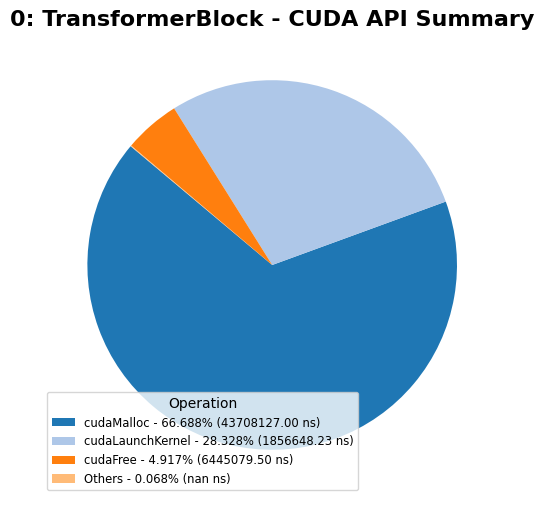

CUDA API Summary Pie Chart Others Items: ['cuGetProcAddress_v2', 'cudaMemcpyAsync', 'cudaEventCreateWithFlags', 'cudaOccupancyMaxActiveBlocksPerMultiprocessor', 'cuInit', 'cudaStreamIsCapturing_v10000', 'cuModuleGetLoadingMode']


<Figure size 600x600 with 0 Axes>

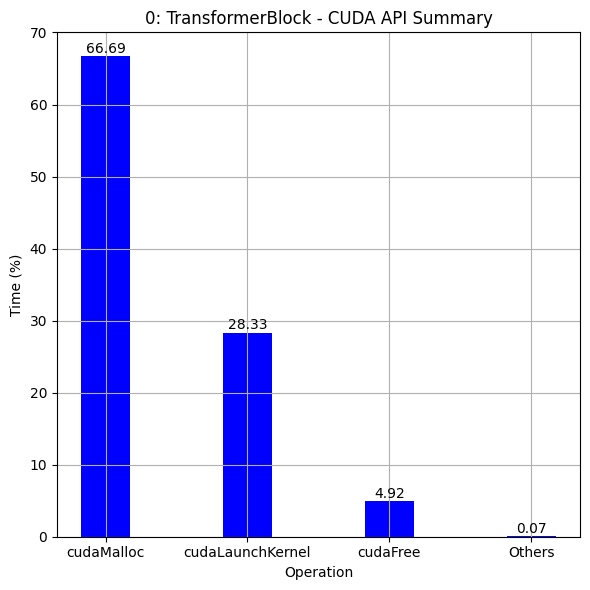

CUDA API Summary Bar Chart Others Items: ['cuGetProcAddress_v2', 'cudaMemcpyAsync', 'cudaEventCreateWithFlags', 'cudaOccupancyMaxActiveBlocksPerMultiprocessor', 'cuInit', 'cudaStreamIsCapturing_v10000', 'cuModuleGetLoadingMode']
########################################################################################################

0: TransformerBlock - GPU Summary Time


,Operation,Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Time (%)
0,[CUDA memcpy Device-to-Device],7456,2,3728.0,3728.0,3648,3808,113.137085,100.0


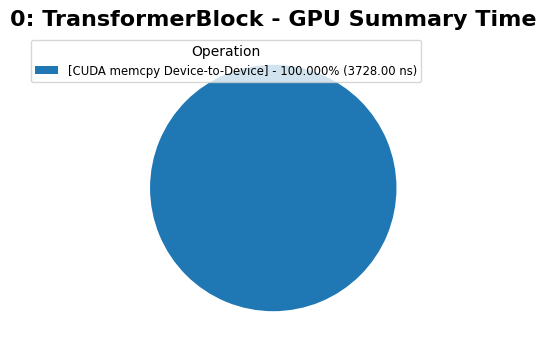

GPU Summary Time Pie Chart Others Items: []


<Figure size 400x400 with 0 Axes>

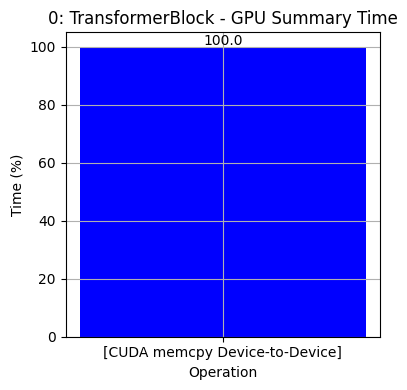

GPU Summary Time Bar Chart Others Items: []

0: TransformerBlock - GPU Summary Size


,Operation,Total (MB),Count,Avg (MB),Med (MB),Min (MB),Max (MB),StdDev (MB),Size_Percent
0,[CUDA memcpy Device-to-Device],0.132,2,0.066,0.066,0.066,0.066,0.0,100.0


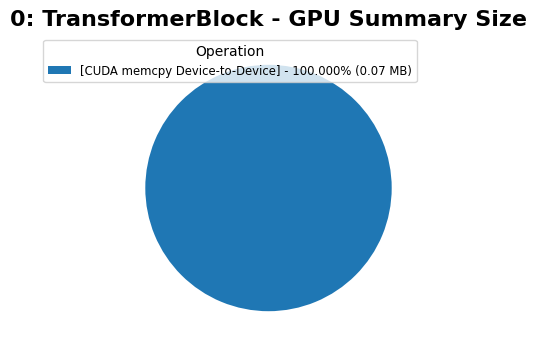

GPU Summary Size Pie Chart Others Items: []


<Figure size 400x400 with 0 Axes>

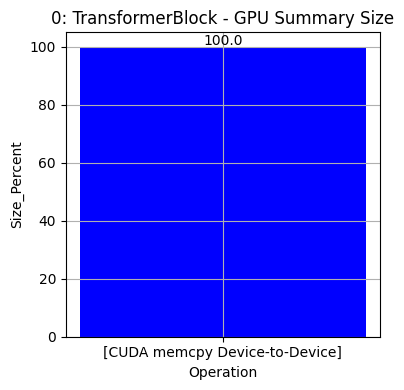

GPU Summary Size Bar Chart Others Items: []
########################################################################################################

0: TransformerBlock - Kernel Functions Summary


,Kernel Name,API Function,Count,KAvg (ns)
0,softmax_warp_forward,cudaLaunchKernel,1,4832.000000
1,vectorized_elementwise_kernel,cudaLaunchKernel,11,3857.454545
2,reduce_kernel,cudaLaunchKernel,2,15504.000000
3,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,cudaLaunchKernel,2,78960.000000
4,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,cudaLaunchKernel,5,48633.600000
5,elementwise_kernel,cudaLaunchKernel,8,6476.000000
6,unrolled_elementwise_kernel,cudaLaunchKernel,10,7427.300000
7,Kernel,cudaLaunchKernel,2,6656.000000


########################################################################################################

0: TransformerBlock - CUDA API to Kernel Mapping


,CorrID,CUDA API,Kernels
0,7541,cudaLaunchKernel,vectorized_elementwise_kernel
2,7555,cudaLaunchKernel,reduce_kernel
4,7565,cudaLaunchKernel,vectorized_elementwise_kernel
6,7575,cudaLaunchKernel,vectorized_elementwise_kernel
8,7585,cudaLaunchKernel,elementwise_kernel
10,7598,cudaLaunchKernel,unrolled_elementwise_kernel
12,7609,cudaLaunchKernel,elementwise_kernel
14,9088,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn
16,9102,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn
18,9116,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn



0: TransformerBlock - CUDA API to Memory Mapping


,CorrID,CUDA API,Memory Operations
0,9210,cudaMemcpyAsync,[CUDA memcpy Device-to-Device]
2,9218,cudaMemcpyAsync,[CUDA memcpy Device-to-Device]


########################################################################################################
API Call Frequency Analysis:


,Operation,Instances
3,cuGetProcAddress_v2,766
1,cudaLaunchKernel,80
5,cudaEventCreateWithFlags,18
6,cudaOccupancyMaxActiveBlocksPerMultiprocessor,10
0,cudaMalloc,8
2,cudaFree,4
4,cudaMemcpyAsync,4
7,cuInit,2
9,cuModuleGetLoadingMode,2
8,cudaStreamIsCapturing_v10000,1


Kernel Latency Analysis:


,Kernel Name,API Start (ns),Kernel Start (ns),Kernel Dur (ns),Latency (ns)
4,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::rsqrt_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 2)]::operator ()() const::[lambda() (instance 2)]::operator ()()...",16402450105,16427906411,3360,25456306
21,"void <unnamed>::softmax_warp_forward<float, float, float, (int)3, (bool)0, (bool)0>(T2 *, const T1 *, int, int, int, const bool *, int, bool)",16700541118,16725476666,4832,24935548
3,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::CUDAFunctorOnSelf_add<float>, at::detail::Array<char *, (int)2>>(int, T2, T3)",16389901245,16401529152,3232,11627907
2,"void at::native::reduce_kernel<(int)512, (int)1, at::native::ReduceOp<float, at::native::MeanOps<float, float, float, float>, unsigned int, float, (int)4>>(T3)",16381815499,16389127132,14496,7311633
36,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::<unnamed>::silu_kernel(at::TensorIteratorBase &)::[lambda() (instance 1)]::operator ()() const::[lambda() (instance 5)]::operator...",16734603389,16738527871,4992,3924482
6,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 10)]::operator ()() co...,16429277646,16429379055,7456,101409
1,"void at::native::vectorized_elementwise_kernel<(int)4, void at::native::<unnamed>::pow_tensor_scalar_kernel_impl<float, float>(at::TensorIteratorBase &, T2)::[lambda(float) (instance 1)], at::deta...",16381258213,16381356806,3616,98593
13,"void at::native::elementwise_kernel<(int)128, (int)2, void at::native::gpu_kernel_impl_nocast<at::native::BinaryFunctor<c10::complex<float>, c10::complex<float>, c10::complex<float>, at::native::b...",16690695543,16690771415,5760,75872
24,"void at::native::elementwise_kernel<(int)128, (int)4, void at::native::gpu_kernel_impl_nocast<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() ...",16727579478,16727651776,7328,72298
5,"void at::native::elementwise_kernel<(int)128, (int)2, void at::native::gpu_kernel_impl_nocast<at::native::BinaryFunctor<float, float, float, at::native::binary_internal::MulFunctor<float>>>(at::Te...",16428762659,16428832589,6176,69930


Kernel Execution Distribution Analysis:


,Kernel Name,Count
1,vectorized_elementwise_kernel,11
6,unrolled_elementwise_kernel,10
5,elementwise_kernel,8
4,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,5
2,reduce_kernel,2
3,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,2
7,Kernel,2
0,softmax_warp_forward,1


Memory Bandwidth Utilization Analysis:


,Name,Duration (ns),Bytes (MB),Bandwidth (GB/s)
1,[CUDA memcpy Device-to-Device],3648,0.066,1.852632e+07
0,[CUDA memcpy Device-to-Device],3808,0.066,1.774790e+07


Concurrency Overlapping Analysis:
No significant overlapping found


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,...,Memory Operation Names,CUDA API to Kernel Mapping,CUDA API to Memory Mapping,CUDA API Summary,Memory Summary by Size,Memory Summary by Time,Kernel Summary,Kernel Summary (Short Names),GPU Kernel CorrIDs,GPU Memory CorrIDs
37,0: TransformerBlock,16380786212,360374211,16380438077,360867255,PushPop,734,734,43,1417,...,[CUDA memcpy Device-to-Device],"[{'CorrID': 7541, 'CUDA API': 'cudaLaunchKernel', 'Kernels': ['void at::native::vectorized_elementwise_kernel<(int)4, void at::native::<unnamed>::pow_tensor_scalar_kernel_impl<float, float>(at::Te...","[{'CorrID': 9210, 'CUDA API': 'cudaMemcpyAsync', 'Memory Operations': ['[CUDA memcpy Device-to-Device]']}, {'CorrID': 9210, 'CUDA API': 'cudaMemcpyAsync', 'Memory Operations': ['[CUDA memcpy Devic...","[{'Time (%)': 66.68771745288996, 'Total Time (ns)': 349665016, 'Instances': 8, 'Avg (ns)': 43708127.0, 'Med (ns)': 250663.5, 'Min (ns)': 10190, 'Max (ns)': 174321091, 'StdDev (ns)': 80616048.87335...","[{'Operation': '[CUDA memcpy Device-to-Device]', 'Total (MB)': 0.132, 'Count': 2, 'Avg (MB)': 0.066, 'Med (MB)': 0.066, 'Min (MB)': 0.066, 'Max (MB)': 0.066, 'StdDev (MB)': 0.0, 'Size_Percent': 10...","[{'Operation': '[CUDA memcpy Device-to-Device]', 'Total Time (ns)': 7456, 'Count': 2, 'Avg (ns)': 3728.0, 'Med (ns)': 3728.0, 'Min (ns)': 3648, 'Max (ns)': 3808, 'StdDev (ns)': 113.137085, 'Time (...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 24940380.0, 'TMed (ns)': 24940380.0, 'TMin (ns)': 24940380, 'TMax (ns)': 24940380, 'TStdDev (ns)': nan, 'AAvg (ns)': 249...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 24940380.0, 'TMed (ns)': 24940380.0, 'TMin (ns)': 24940380, 'TMax (ns)': 24940380, 'TStdDev (ns)': nan, 'AAvg (ns)': 249...","7530,7541,7555,7565,7575,7585,7598,7609,9088,9102,9116,9129,9146,9160,9173,9189,9203,9241,9251,9261,9274,9287,9300,9316,9330,9347,9357,9370,9381,9395,9405,9415,9425,9438,9449,9464,9474,9488,9498,9...","9210,9218"


In [57]:
display_block('0: TransformerBlock', df_nvtx_gpu_proj_trace_processed)

## attention_norm: RMSNorm

########################################################################################################

attention_norm: RMSNorm - CUDA API Summary


,Time (%),Total Time (ns),Instances,Avg (ns),Operation
0,100.0,89428520,14,6.387751e+06,cudaLaunchKernel


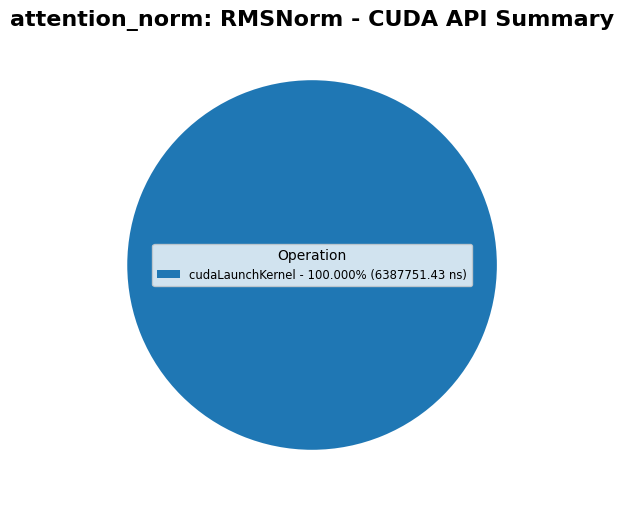

CUDA API Summary Pie Chart Others Items: []


<Figure size 600x600 with 0 Axes>

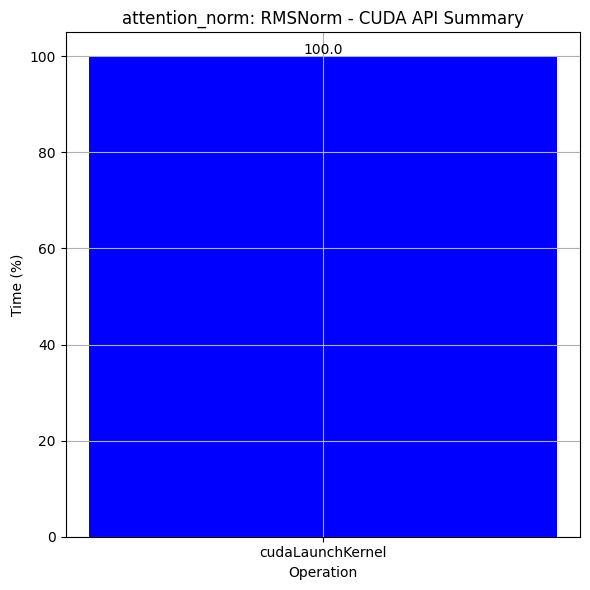

CUDA API Summary Bar Chart Others Items: []
########################################################################################################

attention_norm: RMSNorm - GPU Summary Time
No data found

attention_norm: RMSNorm - GPU Summary Size
No data found
########################################################################################################

attention_norm: RMSNorm - Kernel Functions Summary


,Kernel Name,API Function,Count,KAvg (ns)
0,vectorized_elementwise_kernel,cudaLaunchKernel,3,3402.666667
1,reduce_kernel,cudaLaunchKernel,1,14496.000000
2,elementwise_kernel,cudaLaunchKernel,2,6736.000000
3,unrolled_elementwise_kernel,cudaLaunchKernel,2,7344.000000


########################################################################################################

attention_norm: RMSNorm - CUDA API to Kernel Mapping


,CorrID,CUDA API,Kernels
0,7541,cudaLaunchKernel,vectorized_elementwise_kernel
2,7555,cudaLaunchKernel,reduce_kernel
4,7565,cudaLaunchKernel,vectorized_elementwise_kernel
6,7575,cudaLaunchKernel,vectorized_elementwise_kernel
8,7585,cudaLaunchKernel,elementwise_kernel
10,7598,cudaLaunchKernel,unrolled_elementwise_kernel
12,7609,cudaLaunchKernel,elementwise_kernel



attention_norm: RMSNorm - CUDA API to Memory Mapping
No data found
########################################################################################################
API Call Frequency Analysis:


,Operation,Instances
0,cudaLaunchKernel,14


Kernel Latency Analysis:


,Kernel Name,API Start (ns),Kernel Start (ns),Kernel Dur (ns),Latency (ns)
4,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::rsqrt_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 2)]::operator ()() const::[lambda() (instance 2)]::operator ()()...",16402450105,16427906411,3360,25456306
3,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::CUDAFunctorOnSelf_add<float>, at::detail::Array<char *, (int)2>>(int, T2, T3)",16389901245,16401529152,3232,11627907
2,"void at::native::reduce_kernel<(int)512, (int)1, at::native::ReduceOp<float, at::native::MeanOps<float, float, float, float>, unsigned int, float, (int)4>>(T3)",16381815499,16389127132,14496,7311633
6,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 10)]::operator ()() co...,16429277646,16429379055,7456,101409
1,"void at::native::vectorized_elementwise_kernel<(int)4, void at::native::<unnamed>::pow_tensor_scalar_kernel_impl<float, float>(at::TensorIteratorBase &, T2)::[lambda(float) (instance 1)], at::deta...",16381258213,16381356806,3616,98593
5,"void at::native::elementwise_kernel<(int)128, (int)2, void at::native::gpu_kernel_impl_nocast<at::native::BinaryFunctor<float, float, float, at::native::binary_internal::MulFunctor<float>>>(at::Te...",16428762659,16428832589,6176,69930
7,"void at::native::elementwise_kernel<(int)128, (int)4, void at::native::gpu_kernel_impl_nocast<at::native::BinaryFunctor<c10::Half, c10::Half, c10::Half, at::native::binary_internal::MulFunctor<flo...",16429880492,16429933136,7296,52644
0,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 7)]::operator ()() con...,16380768775,16380786212,7232,17437


Kernel Execution Distribution Analysis:


,Kernel Name,Count
0,vectorized_elementwise_kernel,3
2,elementwise_kernel,2
3,unrolled_elementwise_kernel,2
1,reduce_kernel,1


No data found in Memory Ops
No data found in Kernels or Memory Ops


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,...,Memory Operation Names,CUDA API to Kernel Mapping,CUDA API to Memory Mapping,CUDA API Summary,Memory Summary by Size,Memory Summary by Time,Kernel Summary,Kernel Summary (Short Names),GPU Kernel CorrIDs,GPU Memory CorrIDs
38,attention_norm: RMSNorm,16380786212,49154220,16380450257,49631094,PushPop,734,734,8,1418,...,NaN,"[{'CorrID': 7541, 'CUDA API': 'cudaLaunchKernel', 'Kernels': ['void at::native::vectorized_elementwise_kernel<(int)4, void at::native::<unnamed>::pow_tensor_scalar_kernel_impl<float, float>(at::Te...",[],"[{'Time (%)': 100.0, 'Total Time (ns)': 89428520, 'Instances': 14, 'Avg (ns)': 6387751.428571, 'Med (ns)': 99469.0, 'Min (ns)': 50720, 'Max (ns)': 25458708, 'StdDev (ns)': 9208877.423858, 'Operati...",[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 25459666.0, 'TMed (ns)': 25459666.0, 'TMin (ns)': 25459666, 'TMax (ns)': 25459666, 'TStdDev (ns)': nan, 'AAvg (ns)': 254...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 3, 'QCount': 3, 'TAvg (ns)': 12397671.333333334, 'TMed (ns)': 11631139.0, 'TMin (ns)': 102209, 'TMax (ns)': 25459666, 'TStdDev (ns)': 12696095.275329...","7530,7541,7555,7565,7575,7585,7598,7609",NaN


In [58]:
display_block('attention_norm: RMSNorm', df_nvtx_gpu_proj_trace_processed)

## attention: Attention

########################################################################################################

attention: Attention - CUDA API Summary


,Time (%),Total Time (ns),Instances,Avg (ns),Operation
0,99.849463,50661894,34,1.490056e+06,cudaLaunchKernel
1,0.139441,70750,4,1.768750e+04,cudaMemcpyAsync
2,0.011096,5630,3,1.876667e+03,cudaOccupancyMaxActiveBlocksPerMultiprocessor


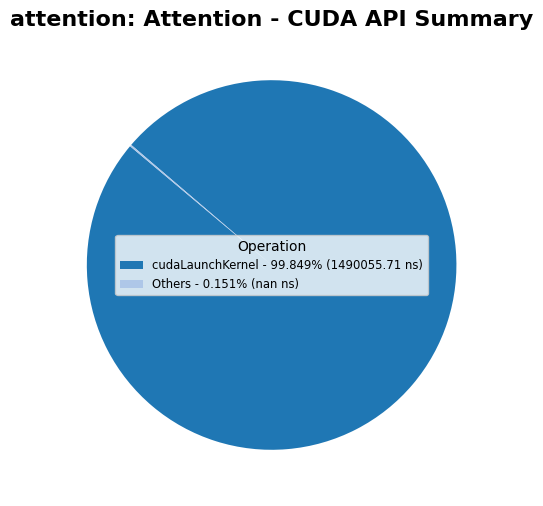

CUDA API Summary Pie Chart Others Items: ['cudaMemcpyAsync', 'cudaOccupancyMaxActiveBlocksPerMultiprocessor']


<Figure size 600x600 with 0 Axes>

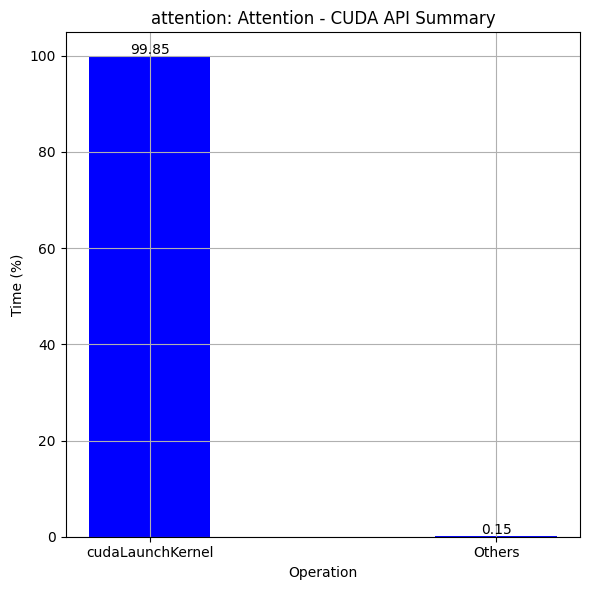

CUDA API Summary Bar Chart Others Items: ['cudaMemcpyAsync', 'cudaOccupancyMaxActiveBlocksPerMultiprocessor']
########################################################################################################

attention: Attention - GPU Summary Time


,Operation,Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Time (%)
0,[CUDA memcpy Device-to-Device],7456,2,3728.0,3728.0,3648,3808,113.137085,100.0


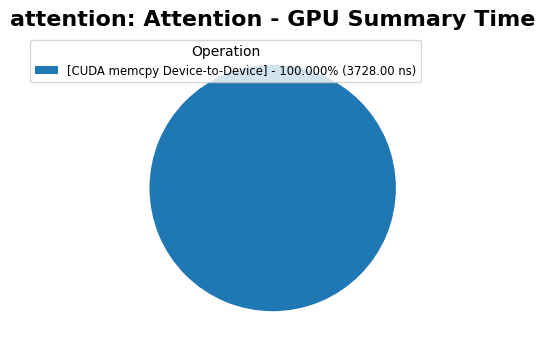

GPU Summary Time Pie Chart Others Items: []


<Figure size 400x400 with 0 Axes>

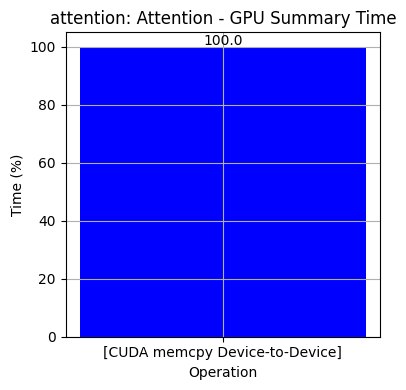

GPU Summary Time Bar Chart Others Items: []

attention: Attention - GPU Summary Size


,Operation,Total (MB),Count,Avg (MB),Med (MB),Min (MB),Max (MB),StdDev (MB),Size_Percent
0,[CUDA memcpy Device-to-Device],0.132,2,0.066,0.066,0.066,0.066,0.0,100.0


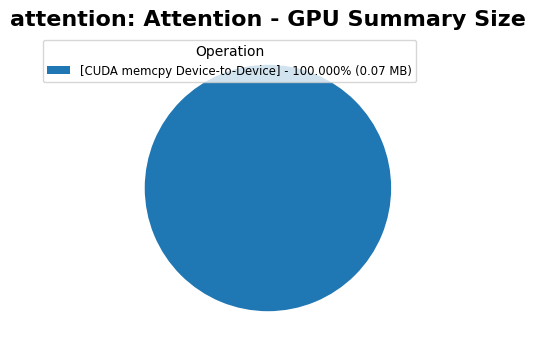

GPU Summary Size Pie Chart Others Items: []


<Figure size 400x400 with 0 Axes>

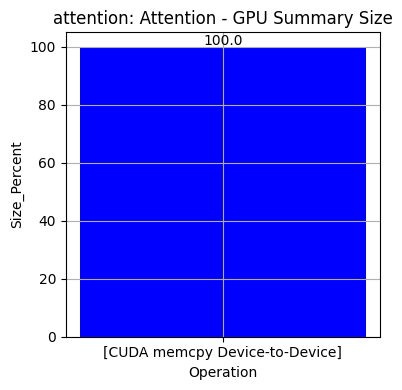

GPU Summary Size Bar Chart Others Items: []
########################################################################################################

attention: Attention - Kernel Functions Summary


,Kernel Name,API Function,Count,KAvg (ns)
0,softmax_warp_forward,cudaLaunchKernel,1,4832.0
1,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,cudaLaunchKernel,4,40328.0
2,elementwise_kernel,cudaLaunchKernel,4,6224.0
3,vectorized_elementwise_kernel,cudaLaunchKernel,1,3424.0
4,unrolled_elementwise_kernel,cudaLaunchKernel,6,7408.0
5,Kernel,cudaLaunchKernel,2,6656.0


########################################################################################################

attention: Attention - CUDA API to Kernel Mapping


,CorrID,CUDA API,Kernels
0,9102,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn
2,9116,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn
4,9129,cudaLaunchKernel,unrolled_elementwise_kernel
6,9146,cudaLaunchKernel,unrolled_elementwise_kernel
8,9160,cudaLaunchKernel,elementwise_kernel
10,9173,cudaLaunchKernel,elementwise_kernel
12,9189,cudaLaunchKernel,unrolled_elementwise_kernel
14,9203,cudaLaunchKernel,unrolled_elementwise_kernel
16,9241,cudaLaunchKernel,Kernel
18,9251,cudaLaunchKernel,vectorized_elementwise_kernel



attention: Attention - CUDA API to Memory Mapping


,CorrID,CUDA API,Memory Operations
0,9210,cudaMemcpyAsync,[CUDA memcpy Device-to-Device]
2,9218,cudaMemcpyAsync,[CUDA memcpy Device-to-Device]


########################################################################################################
API Call Frequency Analysis:


,Operation,Instances
0,cudaLaunchKernel,34
1,cudaMemcpyAsync,4
2,cudaOccupancyMaxActiveBlocksPerMultiprocessor,3


Kernel Latency Analysis:


,Kernel Name,API Start (ns),Kernel Start (ns),Kernel Dur (ns),Latency (ns)
13,"void <unnamed>::softmax_warp_forward<float, float, float, (int)3, (bool)0, (bool)0>(T2 *, const T1 *, int, int, int, const bool *, int, bool)",16700541118,16725476666,4832,24935548
5,"void at::native::elementwise_kernel<(int)128, (int)2, void at::native::gpu_kernel_impl_nocast<at::native::BinaryFunctor<c10::complex<float>, c10::complex<float>, c10::complex<float>, at::native::b...",16690695543,16690771415,5760,75872
16,"void at::native::elementwise_kernel<(int)128, (int)4, void at::native::gpu_kernel_impl_nocast<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() ...",16727579478,16727651776,7328,72298
11,"void at::native::elementwise_kernel<(int)128, (int)4, void at::native::gpu_kernel_impl_nocast<at::native::CUDAFunctor_add<c10::Half>>(at::TensorIteratorBase &, const T1 &)::[lambda(int) (instance ...",16699106096,16699155759,6464,49663
10,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::BUnaryFunctor<c10::Half, c10::Half, c10::Half, at::native::binary_internal::MulFunctor<float>>, at::detail::Array<char *, (int)2>...",16698683809,16698723470,3424,39661
0,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,16684882175,16684915911,47424,33736
3,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 7)]::operator ()() con...,16688661334,16688679921,8896,18587
14,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 10)]::operator ()() co...,16726327755,16726346012,7232,18257
7,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 10)]::operator ()() co...,16692540753,16692556412,7392,15659
1,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,16686837775,16686852844,40384,15069


Kernel Execution Distribution Analysis:


,Kernel Name,Count
4,unrolled_elementwise_kernel,6
1,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,4
2,elementwise_kernel,4
5,Kernel,2
0,softmax_warp_forward,1
3,vectorized_elementwise_kernel,1


Memory Bandwidth Utilization Analysis:


,Name,Duration (ns),Bytes (MB),Bandwidth (GB/s)
1,[CUDA memcpy Device-to-Device],3648,0.066,1.852632e+07
0,[CUDA memcpy Device-to-Device],3808,0.066,1.774790e+07


Concurrency Overlapping Analysis:
No significant overlapping found


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,...,Memory Operation Names,CUDA API to Kernel Mapping,CUDA API to Memory Mapping,CUDA API Summary,Memory Summary by Size,Memory Summary by Time,Kernel Summary,Kernel Summary (Short Names),GPU Kernel CorrIDs,GPU Memory CorrIDs
68,attention: Attention,16684915911,43585148,16430096151,299021729,PushPop,734,734,20,1418,...,[CUDA memcpy Device-to-Device],"[{'CorrID': 9102, 'CUDA API': 'cudaLaunchKernel', 'Kernels': ['ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn']}, {'CorrID': 9102, 'CUDA API': 'cudaLaunchKernel', 'Kernels': [...","[{'CorrID': 9210, 'CUDA API': 'cudaMemcpyAsync', 'Memory Operations': ['[CUDA memcpy Device-to-Device]']}, {'CorrID': 9210, 'CUDA API': 'cudaMemcpyAsync', 'Memory Operations': ['[CUDA memcpy Devic...","[{'Time (%)': 99.84946275468496, 'Total Time (ns)': 50661894, 'Instances': 34, 'Avg (ns)': 1490055.705882, 'Med (ns)': 13860.0, 'Min (ns)': 11670, 'Max (ns)': 24937342, 'StdDev (ns)': 5949933.7207...","[{'Operation': '[CUDA memcpy Device-to-Device]', 'Total (MB)': 0.132, 'Count': 2, 'Avg (MB)': 0.066, 'Med (MB)': 0.066, 'Min (MB)': 0.066, 'Max (MB)': 0.066, 'StdDev (MB)': 0.0, 'Size_Percent': 10...","[{'Operation': '[CUDA memcpy Device-to-Device]', 'Total Time (ns)': 7456, 'Count': 2, 'Avg (ns)': 3728.0, 'Med (ns)': 3728.0, 'Min (ns)': 3648, 'Max (ns)': 3808, 'StdDev (ns)': 113.137085, 'Time (...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 24940380.0, 'TMed (ns)': 24940380.0, 'TMin (ns)': 24940380, 'TMax (ns)': 24940380, 'TStdDev (ns)': nan, 'AAvg (ns)': 249...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 24940380.0, 'TMed (ns)': 24940380.0, 'TMin (ns)': 24940380, 'TMax (ns)': 24940380, 'TStdDev (ns)': nan, 'AAvg (ns)': 249...","9088,9102,9116,9129,9146,9160,9173,9189,9203,9241,9251,9261,9274,9287,9300,9316,9330,9347","9210,9218"


In [59]:
display_block('attention: Attention', df_nvtx_gpu_proj_trace_processed)

## feed_forward: FeedForward

########################################################################################################

feed_forward: FeedForward - CUDA API Summary


,Time (%),Total Time (ns),Instances,Avg (ns),Operation
0,99.935773,8028824,8,1003603.0,cudaLaunchKernel
1,0.064227,5160,3,1720.0,cudaOccupancyMaxActiveBlocksPerMultiprocessor


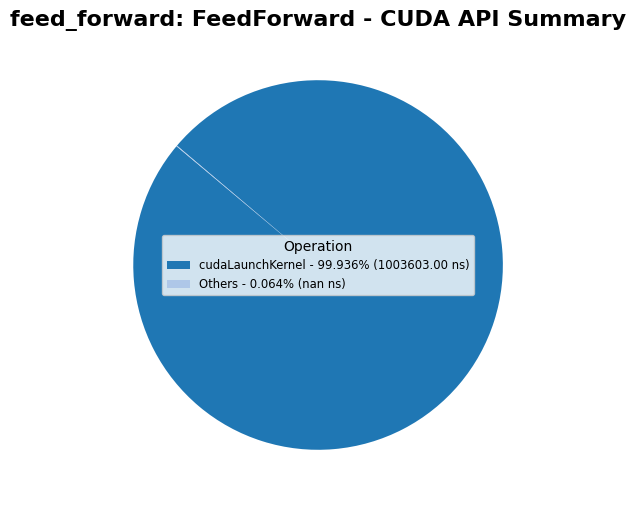

CUDA API Summary Pie Chart Others Items: ['cudaOccupancyMaxActiveBlocksPerMultiprocessor']


<Figure size 600x600 with 0 Axes>

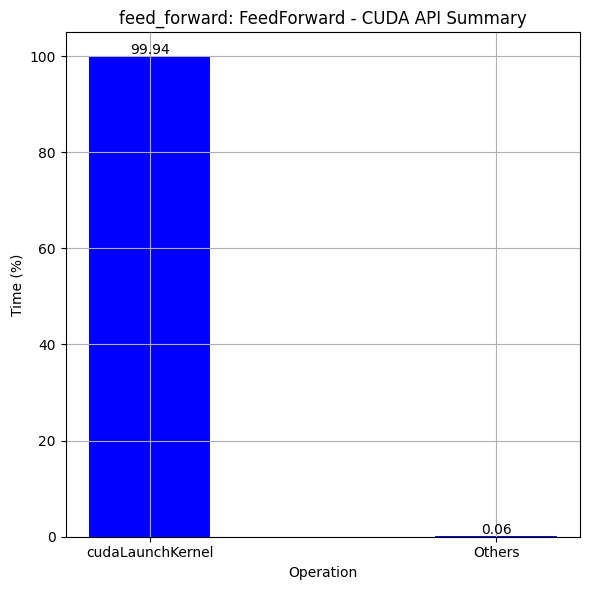

CUDA API Summary Bar Chart Others Items: ['cudaOccupancyMaxActiveBlocksPerMultiprocessor']
########################################################################################################

feed_forward: FeedForward - GPU Summary Time
No data found

feed_forward: FeedForward - GPU Summary Size
No data found
########################################################################################################

feed_forward: FeedForward - Kernel Functions Summary


,Kernel Name,API Function,Count,KAvg (ns)
0,vectorized_elementwise_kernel,cudaLaunchKernel,2,4928.0
1,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,cudaLaunchKernel,1,81856.0
2,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,cudaLaunchKernel,2,78960.0


########################################################################################################

feed_forward: FeedForward - CUDA API to Kernel Mapping


,CorrID,CUDA API,Kernels
0,9474,cudaLaunchKernel,vectorized_elementwise_kernel
2,9488,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn
4,9498,cudaLaunchKernel,vectorized_elementwise_kernel
6,9513,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn



feed_forward: FeedForward - CUDA API to Memory Mapping
No data found
########################################################################################################
API Call Frequency Analysis:


,Operation,Instances
0,cudaLaunchKernel,8
1,cudaOccupancyMaxActiveBlocksPerMultiprocessor,3


Kernel Latency Analysis:


,Kernel Name,API Start (ns),Kernel Start (ns),Kernel Dur (ns),Latency (ns)
1,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::<unnamed>::silu_kernel(at::TensorIteratorBase &)::[lambda() (instance 1)]::operator ()() const::[lambda() (instance 5)]::operator...",16734603389,16738527871,4992,3924482
3,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::BinaryFunctor<c10::Half, c10::Half, c10::Half, at::native::binary_internal::MulFunctor<float>>, at::detail::Array<char *, (int)3>...",16739889060,16739955363,4864,66303
0,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,16733715884,16733731698,79936,15814
2,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,16739516432,16739531714,77984,15282
4,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,16740392177,16740405765,81856,13588


Kernel Execution Distribution Analysis:


,Kernel Name,Count
0,vectorized_elementwise_kernel,2
2,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,2
1,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,1


No data found in Memory Ops
No data found in Kernels or Memory Ops


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,...,Memory Operation Names,CUDA API to Kernel Mapping,CUDA API to Memory Mapping,CUDA API Summary,Memory Summary by Size,Memory Summary by Time,Kernel Summary,Kernel Summary (Short Names),GPU Kernel CorrIDs,GPU Memory CorrIDs
190,feed_forward: FeedForward,16733731698,6755923,16732950508,7928446,PushPop,734,734,5,1418,...,NaN,"[{'CorrID': 9474, 'CUDA API': 'cudaLaunchKernel', 'Kernels': ['void at::native::vectorized_elementwise_kernel<(int)4, at::native::<unnamed>::silu_kernel(at::TensorIteratorBase &)::[lambda() (insta...",[],"[{'Time (%)': 99.93577283698846, 'Total Time (ns)': 8028824, 'Instances': 8, 'Avg (ns)': 1003603.0, 'Med (ns)': 39284.5, 'Min (ns)': 11990, 'Max (ns)': 3923888, 'StdDev (ns)': 1802511.273077, 'Ope...",[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 3929474.0, 'TMed (ns)': 3929474.0, 'TMin (ns)': 3929474, 'TMax (ns)': 3929474, 'TStdDev (ns)': nan, 'AAvg (ns)': 3923888...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 2, 'QCount': 2, 'TAvg (ns)': 2000320.5, 'TMed (ns)': 2000320.5, 'TMin (ns)': 71167, 'TMax (ns)': 3929474, 'TStdDev (ns)': 2728235.0435995245, 'AAvg (...","9464,9474,9488,9498,9513",NaN


In [60]:
# feed_forward: FeedForward
display_block('feed_forward: FeedForward', df_nvtx_gpu_proj_trace_processed)

## ffn_norm: RMSNorm

########################################################################################################

ffn_norm: RMSNorm - CUDA API Summary


,Time (%),Total Time (ns),Instances,Avg (ns),Operation
0,100.0,174910,14,12493.571429,cudaLaunchKernel


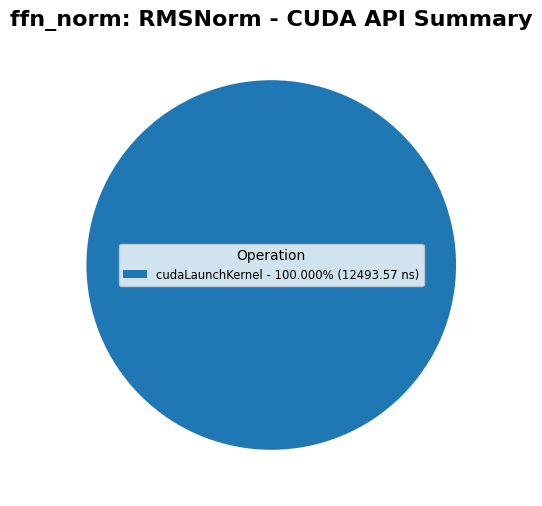

CUDA API Summary Pie Chart Others Items: []


<Figure size 600x600 with 0 Axes>

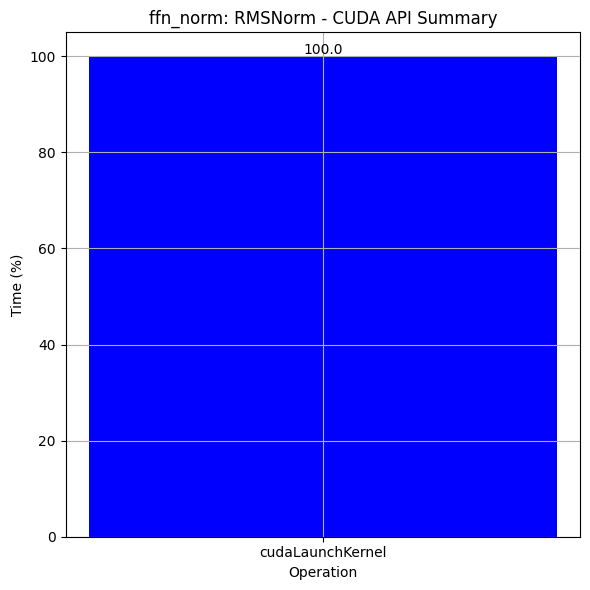

CUDA API Summary Bar Chart Others Items: []
########################################################################################################

ffn_norm: RMSNorm - GPU Summary Time
No data found

ffn_norm: RMSNorm - GPU Summary Size
No data found
########################################################################################################

ffn_norm: RMSNorm - Kernel Functions Summary


,Kernel Name,API Function,Count,KAvg (ns)
0,reduce_kernel,cudaLaunchKernel,1,16512.0
1,unrolled_elementwise_kernel,cudaLaunchKernel,2,7568.5
2,elementwise_kernel,cudaLaunchKernel,2,6720.0
3,vectorized_elementwise_kernel,cudaLaunchKernel,3,3424.0


########################################################################################################

ffn_norm: RMSNorm - CUDA API to Kernel Mapping


,CorrID,CUDA API,Kernels
0,9381,cudaLaunchKernel,vectorized_elementwise_kernel
2,9395,cudaLaunchKernel,reduce_kernel
4,9405,cudaLaunchKernel,vectorized_elementwise_kernel
6,9415,cudaLaunchKernel,vectorized_elementwise_kernel
8,9425,cudaLaunchKernel,elementwise_kernel
10,9438,cudaLaunchKernel,unrolled_elementwise_kernel
12,9449,cudaLaunchKernel,elementwise_kernel



ffn_norm: RMSNorm - CUDA API to Memory Mapping
No data found
########################################################################################################
API Call Frequency Analysis:


,Operation,Instances
0,cudaLaunchKernel,14


Kernel Latency Analysis:


,Kernel Name,API Start (ns),Kernel Start (ns),Kernel Dur (ns),Latency (ns)
4,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::rsqrt_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 2)]::operator ()() const::[lambda() (instance 2)]::operator ()()...",16731525596,16731540395,3360,14799
2,"void at::native::reduce_kernel<(int)512, (int)1, at::native::ReduceOp<float, at::native::MeanOps<float, float, float, float>, unsigned int, float, (int)4>>(T3)",16730715741,16730730345,16512,14604
0,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 7)]::operator ()() con...,16729784846,16729799334,7105,14488
1,"void at::native::vectorized_elementwise_kernel<(int)4, void at::native::<unnamed>::pow_tensor_scalar_kernel_impl<float, float>(at::TensorIteratorBase &, T2)::[lambda(float) (instance 1)], at::deta...",16730119994,16730134439,3616,14445
5,"void at::native::elementwise_kernel<(int)128, (int)2, void at::native::gpu_kernel_impl_nocast<at::native::BinaryFunctor<float, float, float, at::native::binary_internal::MulFunctor<float>>>(at::Te...",16731899904,16731914156,6208,14252
6,void at::native::unrolled_elementwise_kernel<at::native::direct_copy_kernel_cuda(at::TensorIteratorBase &)::[lambda() (instance 3)]::operator ()() const::[lambda() (instance 10)]::operator ()() co...,16732337142,16732350926,8032,13784
7,"void at::native::elementwise_kernel<(int)128, (int)4, void at::native::gpu_kernel_impl_nocast<at::native::BinaryFunctor<c10::Half, c10::Half, c10::Half, at::native::binary_internal::MulFunctor<flo...",16732851279,16732864911,7232,13632
3,"void at::native::vectorized_elementwise_kernel<(int)4, at::native::CUDAFunctorOnSelf_add<float>, at::detail::Array<char *, (int)2>>(int, T2, T3)",16731115559,16731129162,3296,13603


Kernel Execution Distribution Analysis:


,Kernel Name,Count
3,vectorized_elementwise_kernel,3
1,unrolled_elementwise_kernel,2
2,elementwise_kernel,2
0,reduce_kernel,1


No data found in Memory Ops
No data found in Kernels or Memory Ops


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,...,Memory Operation Names,CUDA API to Kernel Mapping,CUDA API to Memory Mapping,CUDA API Summary,Memory Summary by Size,Memory Summary by Time,Kernel Summary,Kernel Summary (Short Names),GPU Kernel CorrIDs,GPU Memory CorrIDs
160,ffn_norm: RMSNorm,16729799334,3072809,16729518457,3423621,PushPop,734,734,8,1418,...,NaN,"[{'CorrID': 9381, 'CUDA API': 'cudaLaunchKernel', 'Kernels': ['void at::native::vectorized_elementwise_kernel<(int)4, void at::native::<unnamed>::pow_tensor_scalar_kernel_impl<float, float>(at::Te...",[],"[{'Time (%)': 100.0, 'Total Time (ns)': 174910, 'Instances': 14, 'Avg (ns)': 12493.571429, 'Med (ns)': 12335.0, 'Min (ns)': 11350, 'Max (ns)': 13810, 'StdDev (ns)': 713.761511, 'Operation': 'cudaL...",[],[],"[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 31116.0, 'TMed (ns)': 31116.0, 'TMin (ns)': 31116, 'TMax (ns)': 31116, 'TStdDev (ns)': nan, 'AAvg (ns)': 13810.0, 'AMed ...","[{'PID': 734, 'TID': 734, 'DevId': 0, 'Count': 1, 'QCount': 1, 'TAvg (ns)': 31116.0, 'TMed (ns)': 31116.0, 'TMin (ns)': 31116, 'TMax (ns)': 31116, 'TStdDev (ns)': nan, 'AAvg (ns)': 13810.0, 'AMed ...","9370,9381,9395,9405,9415,9425,9438,9449",NaN


In [61]:
# ffn_norm: RMSNorm
display_block('ffn_norm: RMSNorm', df_nvtx_gpu_proj_trace_processed)

# Other

In [62]:
# aten::embedding
display_block('aten::embedding', df_nvtx_gpu_proj_trace_processed)

No data found for Name: aten::embedding
